In [237]:
from datetime import datetime, date
import string
import pandas as pd
import numpy as np
import re
import nltk
import spacy
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns

import tensorflow as tf

np.random.seed(1)
tf.random.set_seed(1)

# Load data

In [238]:
custom_date_parser = lambda x: datetime.strptime(x, "%m/%d/%Y")

df_latest = pd.read_csv("final_postcovid.csv", parse_dates=['date'], date_parser=custom_date_parser)
df_earliest = pd.read_csv("final_precovid.csv", parse_dates=['date'], date_parser=custom_date_parser)

# Data preprocess
### Cleaning reviews

In [239]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def comment_preprocess(text):
    text = text.lower()
    text = re.sub("won\'t", "will not", text)
    text = re.sub("can\'t", "can not", text)
    text = re.sub("don\'t", "do not", text)
    text = re.sub("didn\'t", "did not", text)
    text = re.sub("shouldn\'t", "should not", text)
    text = re.sub("\'ll", "will", text)
    
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+',' ', text)
    text = re.sub(r'&amp?;',' ', text)
    text = re.sub(r'&lt;',' ', text)
    text = re.sub(r'&gt;',' ', text)
    
    text = re.sub(r'\d{2}:\d{2}:\d{2}', ' ', text)
    text = re.sub(r'UTC', ' ', text)
    text = re.sub(r'\d{2}km', ' ', text)
    text = re.sub(r"\b\d+\b", " ", text) # removing the numbers

    text = re.sub(r"#","",text) 
    text = re.sub(r"(?:\@)\w+", ' ', text)
    text = re.sub(r'\n', ' ', text)
    
    text = text.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
    text = re.sub(' +', ' ', text) # remove multiple spaces
    
    # text = [word for word in word_tokenize(text) if not word in stopwords.words('english')]
    doc = nlp(text)
    text = " ".join([token.lemma_ for token in doc])
    
    return text

In [240]:
df_latest["Comment"] = df_latest["Comment"].apply(comment_preprocess)
df_earliest["Comment"] = df_latest["Comment"].apply(comment_preprocess)

### Cleaning ratings
1 star and 2 star ratings are converted to "bad rating" (0) while 4 star and 5 star ratings are converted to "good rating" (1). 3 star rating data are removed.

In [241]:
df_latest["Rating"].replace({"1 star rating": 0, "2 star rating": 0, "4 star rating": 1, "5 star rating": 1}, inplace=True)
df_earliest["Rating"].replace({"1 star rating": 0, "2 star rating": 0, "4 star rating": 1, "5 star rating": 1}, inplace=True)

c:\users\w2673\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


1                1661
0                 401
3 star rating     320
Name: Rating, dtype: int64

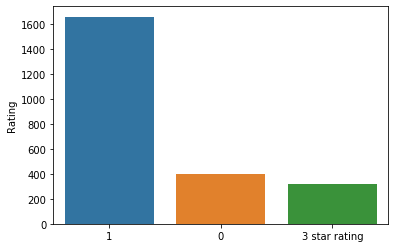

In [242]:
count = df_earliest['Rating'].value_counts()
sns.barplot(count.index, count)
count

c:\users\w2673\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


1                1566
0                 588
3 star rating     253
Name: Rating, dtype: int64

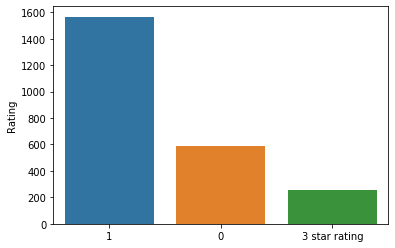

In [243]:
count = df_latest['Rating'].value_counts()
sns.barplot(count.index, count)
count

In [244]:
df_latest = df_latest[df_latest['Rating'] != '3 star rating']
df_earliest = df_earliest[df_earliest['Rating'] != '3 star rating']

# Feature Engineering
Create column based on the timestamp of data

In [245]:
# Let postcovid be 1 and precovid be 0
df_latest['Time'] = 1
df_earliest['Time'] = 0

Combine data from files and split the data into training / testing sets

In [246]:
df = pd.concat([df_latest[['Comment', 'Rating']], df_earliest[['Comment', 'Rating']]])

In [247]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['Comment'], df['Rating'].astype("int"), 
                                                    test_size = 0.20, random_state = 42)

# Modeling 
## Vader Polarity Analysis

In [248]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize

def VADER_predict(inputs):

    sid = SentimentIntensityAnalyzer()
    predicts = []
    
    for input in inputs:
        score = sid.polarity_scores(input)['compound']
        if score>0:
            predicts.append(1)
        else:
            predicts.append(0)
  
    return predicts

In [249]:
train_pred = VADER_predict(X_train)

In [250]:
from sklearn.metrics import classification_report

target_names = ['bad rating', 'good rating']
print(classification_report(y_train.astype("int"), train_pred, target_names=target_names))

              precision    recall  f1-score   support

  bad rating       0.57      0.40      0.47       796
 good rating       0.83      0.91      0.87      2576

    accuracy                           0.79      3372
   macro avg       0.70      0.65      0.67      3372
weighted avg       0.77      0.79      0.77      3372



## Word2Vec using Gensim
Stochastic Logistic Regression is applied to model word vectors

In [251]:
from gensim.models.word2vec import Word2Vec

x_train = X_train
x_test = X_test
n_dim = 300
#Initialize model and build vocab
yelp_w2v = Word2Vec(vector_size=n_dim, min_count=10)
yelp_w2v.build_vocab(X_train)
#Train the model over train_reviews (this may take several minutes)
yelp_w2v.train(X_train, total_examples=len(X_train), epochs=2)

(492862, 2862308)

In [252]:
def buildWordVector(text, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in text:
        try:
            vec += yelp_w2v.wv[word].reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec

In [253]:
from sklearn.preprocessing import scale
train_vecs = np.concatenate([buildWordVector(z, n_dim) for z in x_train])
train_vecs = scale(train_vecs)
#Train word2vec on test tweets
yelp_w2v.train(X_test, total_examples=len(X_test), epochs=2)

(118018, 685588)

In [254]:
#Build test tweet vectors then scale
test_vecs = np.concatenate([buildWordVector(z, n_dim) for z in x_test])
test_vecs = scale(test_vecs)

In [255]:
#Use classification algorithm (i.e. Stochastic Logistic Regression) on training set, then assess model performance on test set
from sklearn.linear_model import SGDClassifier
lr = SGDClassifier(loss='log', penalty='l2')
lr.fit(train_vecs, y_train)
print('Test Accuracy: %.2f'%lr.score(test_vecs, y_test))

Test Accuracy: 0.71


In [256]:
test_pred = lr.predict(test_vecs)
target_names = ['bad rating', 'good rating']
print(classification_report(y_test, test_pred, target_names=target_names))

              precision    recall  f1-score   support

  bad rating       0.28      0.18      0.22       193
 good rating       0.78      0.87      0.82       651

    accuracy                           0.71       844
   macro avg       0.53      0.52      0.52       844
weighted avg       0.67      0.71      0.68       844



## LSTM

In [297]:
nltk.download('stopwords')
nltk.download('punkt')
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\w2673\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\w2673\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Here we have to reload the data because we need to re-clean our data for Deep Learning based models

In [298]:
df_post= pd.read_csv('final_postcovid.csv')
df_post.rename(columns={'Unnamed: 0':'id'}, inplace=True)
df_post.head(3)

,id,Comment,Rating,date,restaurant,restaurant rating,ammenity,notammenity
0,0,I was trying to order pick up on a Friday nigh...,1 star rating,11/12/2021,Grand Vin,3 star rating,Takes Reservations\nOffers Delivery\nOffers Ta...,Accepts Apple Pay\nNot Good For Dancing\nNo Sm...
1,1,walking around hoboken with hubby looking for ...,5 star rating,11/10/2021,Grand Vin,3 star rating,Takes Reservations\nOffers Delivery\nOffers Ta...,Accepts Apple Pay\nNot Good For Dancing\nNo Sm...
2,2,Grand Vin is a staple for drinks and dinner. R...,4 star rating,11/5/2021,Grand Vin,3 star rating,Takes Reservations\nOffers Delivery\nOffers Ta...,Accepts Apple Pay\nNot Good For Dancing\nNo Sm...


In [299]:
df_pre= pd.read_csv('final_precovid.csv')
df_pre.rename(columns={'Unnamed: 0':'id'}, inplace=True)
df_pre.head(3)

,id,Comment,Rating,date,restaurant,restaurant rating,ammenity,notammenity
0,0,Came down for a quick bite after a long day. W...,2 star rating,3/2/2016,Grand Vin,3 star rating,Takes Reservations\nOffers Delivery\nOffers Ta...,Accepts Apple Pay\nNot Good For Dancing\nNo Sm...
1,1,Ate dinner at Grand Vin last night - was not d...,5 star rating,3/2/2016,Grand Vin,3 star rating,Takes Reservations\nOffers Delivery\nOffers Ta...,Accepts Apple Pay\nNot Good For Dancing\nNo Sm...
2,2,Excellent date spot or night out. Had the veal...,5 star rating,3/4/2016,Grand Vin,3 star rating,Takes Reservations\nOffers Delivery\nOffers Ta...,Accepts Apple Pay\nNot Good For Dancing\nNo Sm...


In [300]:
df_post["Rating"].replace({"1 star rating": "negative", "2 star rating": "negative", "4 star rating": "positive", "5 star rating": "positive"}, inplace=True)
df_pre["Rating"].replace({"1 star rating": "negative", "2 star rating": "negative", "4 star rating": "positive", "5 star rating": "positive"}, inplace=True)

In [301]:
df_post = df_post[df_post['Rating'] != '3 star rating']
df_pre = df_pre[df_pre['Rating'] != '3 star rating']
df_post = df_post[['Comment','Rating']]
df_pre = df_pre[['Comment','Rating']]
df = pd.concat([df_post,df_pre])

In [302]:
df['Comment'] = df['Comment'].str.lower()
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
    #text = re.sub(r'\W+', '', text)
    #text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text
    return text
df['Comment'] = df['Comment'].apply(clean_text)

In [303]:
max_encoder_seq_length = max(len(line) for line in df['Comment'])

print('max length of input  sentences: %d' % (max_encoder_seq_length))

max length of input  sentences: 4192


In [304]:
from keras.preprocessing.text import Tokenizer

vocabulary = 400
tokenizer = Tokenizer(num_words=vocabulary)
tokenizer.fit_on_texts(df['Comment'])
word_index = tokenizer.word_index
sequences_train = tokenizer.texts_to_sequences(df['Comment'])

from keras import preprocessing
word_num = 30
X = preprocessing.sequence.pad_sequences(sequences_train, word_num)
X.shape

(4216, 30)

### Re-split data

In [305]:
Y = df['Rating']
Y = pd.get_dummies(Y).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)


We put Embedding layer, Spatial Dropout=0.2, LSTM layer and finally a 2-node layer for binary classification

In [266]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras import regularizers

# LSTM
embed_dim = 128
lstm_out = 64

model = Sequential()
model.add(Embedding(vocabulary, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2,kernel_regularizer=regularizers.l2(0.002)))
model.add(Dense(2,activation='sigmoid'))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', keras.metrics.Recall(), keras.metrics.Precision()])
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 30, 128)           51200     
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 30, 128)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 130       
Total params: 100,738
Trainable params: 100,738
Non-trainable params: 0
_________________________________________________________________
None


We train our model with up to 30 epochs. This would be terminated by early stopping if the accuracy stagnates.

In [267]:
batch_size = 32
history = model.fit(X_train, Y_train, epochs = 30, batch_size=batch_size,validation_data=(X_test,Y_test),verbose = True,callbacks=[es])

Epoch 1/30
106/106 [==============================] - 9s 37ms/step - loss: 0.6179 - accuracy: 0.7891 - recall_6: 0.7906 - precision_6: 0.7885 - val_loss: 0.3665 - val_accuracy: 0.8519 - val_recall_6: 0.8507 - val_precision_6: 0.8507
Epoch 2/30
106/106 [==============================] - 3s 30ms/step - loss: 0.3423 - accuracy: 0.8719 - recall_6: 0.8725 - precision_6: 0.8707 - val_loss: 0.3168 - val_accuracy: 0.8637 - val_recall_6: 0.8649 - val_precision_6: 0.8639
Epoch 3/30
106/106 [==============================] - 3s 30ms/step - loss: 0.2932 - accuracy: 0.8861 - recall_6: 0.8864 - precision_6: 0.8862 - val_loss: 0.3124 - val_accuracy: 0.8720 - val_recall_6: 0.8720 - val_precision_6: 0.8720
Epoch 4/30
106/106 [==============================] - 3s 27ms/step - loss: 0.2773 - accuracy: 0.8867 - recall_6: 0.8876 - precision_6: 0.8860 - val_loss: 0.3145 - val_accuracy: 0.8614 - val_recall_6: 0.8637 - val_precision_6: 0.8617
Epoch 5/30
106/106 [==============================] - 3s 27ms/step -

27/27 [==============================] - 0s 5ms/step - loss: 0.3749 - accuracy: 0.8649 - recall_6: 0.8661 - precision_6: 0.8651
Test set
  Loss: 0.375
  Accuracy: 0.865


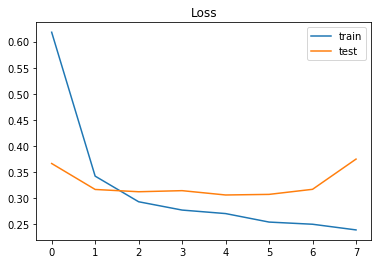

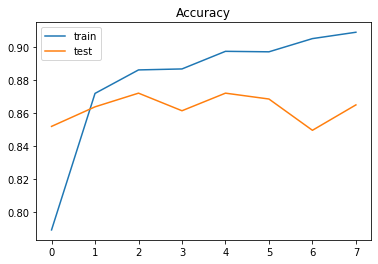

In [268]:
import matplotlib.pyplot as plt

accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [295]:
def one_hot_category_transfer(Y):
    wi=[]
    for y in Y:
        wi.append(np.argmax(y))
    return wi

In [296]:
test_pred = model.predict(X_test)
test_pred = one_hot_category_transfer(test_pred)
target_names = ['bad rating', 'good rating']
print(classification_report(y_test, test_pred, target_names=target_names))

              precision    recall  f1-score   support

  bad rating       0.00      0.00      0.00       193
 good rating       0.77      1.00      0.87       651

    accuracy                           0.77       844
   macro avg       0.39      0.50      0.44       844
weighted avg       0.59      0.77      0.67       844



c:\users\w2673\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\w2673\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\w2673\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

## CNN

In [306]:
from keras import models
from keras.layers import Conv1D, GlobalMaxPooling1D, Flatten, GlobalAveragePooling2D, Activation

maxlen = 30
batch_size = 32
embedding_dims = 6
filters = 10
kernel_size1 = 3
hidden_dims = 13

model = models.Sequential()
model.add(Embedding(vocabulary,embedding_dims,input_length=maxlen))
model.add(Conv1D(filters,kernel_size1,padding='valid',activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Flatten())
model.add(Dense(hidden_dims))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])

In [307]:
history = model.fit(X_train, Y_train, epochs=15, batch_size=batch_size, validation_split=0.1)

Epoch 1/15
95/95 [==============================] - 1s 4ms/step - loss: 0.5918 - acc: 0.7643 - val_loss: 0.5404 - val_acc: 0.7604
Epoch 2/15
95/95 [==============================] - 0s 2ms/step - loss: 0.5135 - acc: 0.7643 - val_loss: 0.4868 - val_acc: 0.7604
Epoch 3/15
95/95 [==============================] - 0s 2ms/step - loss: 0.4571 - acc: 0.7643 - val_loss: 0.4218 - val_acc: 0.7604
Epoch 4/15
95/95 [==============================] - 0s 2ms/step - loss: 0.4049 - acc: 0.7643 - val_loss: 0.3781 - val_acc: 0.7604
Epoch 5/15
95/95 [==============================] - 0s 2ms/step - loss: 0.3697 - acc: 0.8036 - val_loss: 0.3543 - val_acc: 0.8195
Epoch 6/15
95/95 [==============================] - 0s 2ms/step - loss: 0.3377 - acc: 0.8612 - val_loss: 0.3285 - val_acc: 0.8698
Epoch 7/15
95/95 [==============================] - 0s 2ms/step - loss: 0.3023 - acc: 0.8922 - val_loss: 0.3063 - val_acc: 0.8787
Epoch 8/15
95/95 [==============================] - 0s 2ms/step - loss: 0.2670 - acc: 0.90

27/27 [==============================] - 0s 2ms/step - loss: 0.3705 - acc: 0.8673
Test set
  Loss: 0.370
  Accuracy: 0.867


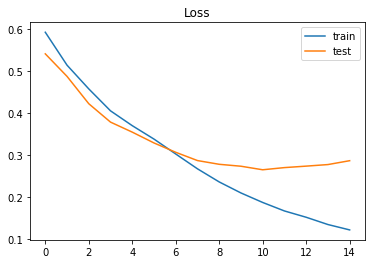

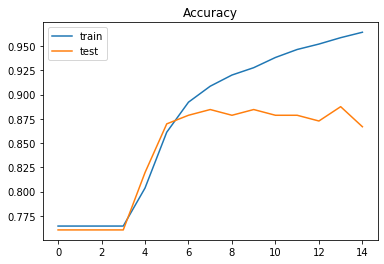

In [310]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [311]:
test_pred = model.predict(X_test)
test_pred = one_hot_category_transfer(test_pred)
target_names = ['bad rating', 'good rating']
print(classification_report(y_test, test_pred, target_names=target_names))

              precision    recall  f1-score   support

  bad rating       0.74      0.65      0.69       193
 good rating       0.90      0.93      0.92       651

    accuracy                           0.87       844
   macro avg       0.82      0.79      0.80       844
weighted avg       0.86      0.87      0.86       844



## Decision tree with Feature Importance

In [280]:
df_latest = pd.read_csv("final_postcovid.csv", parse_dates=['date'], date_parser=custom_date_parser)
df_earliest = pd.read_csv("final_precovid.csv", parse_dates=['date'], date_parser=custom_date_parser)

In [281]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def comment_preprocess(text):
    text = text.lower()
    text = re.sub("won\'t", "will not", text)
    text = re.sub("can\'t", "can not", text)
    text = re.sub("don\'t", "do not", text)
    text = re.sub("didn\'t", "did not", text)
    text = re.sub("shouldn\'t", "should not", text)
    text = re.sub("\'ll", "will", text)
    
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+',' ', text)
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
    
    text = text.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
    text = re.sub(' +', ' ', text) # remove multiple spaces
    
    # text = [word for word in word_tokenize(text) if not word in stopwords.words('english')]
    doc = nlp(text)
    text = " ".join([token.lemma_ for token in doc])
    
    return text

In [282]:
df_latest["Comment"] = df_latest["Comment"].apply(comment_preprocess)
df_earliest["Comment"] = df_earliest["Comment"].apply(comment_preprocess)

In [283]:
df_latest["Rating"].replace({"1 star rating": 0, "2 star rating": 0, "4 star rating": 1, "5 star rating": 1}, inplace=True)
df_earliest["Rating"].replace({"1 star rating": 0, "2 star rating": 0, "4 star rating": 1, "5 star rating": 1}, inplace=True)
df_latest = df_latest[df_latest['Rating'] != '3 star rating']
df_earliest = df_earliest[df_earliest['Rating'] != '3 star rating']

In [284]:
# Let postcovid be 1 and precovid be 0
df_latest['Time'] = 1
df_earliest['Time'] = 0

df = pd.concat([df_latest, df_earliest])

In [285]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')

In [286]:
X = vectorizer.fit_transform(df['Comment'])
X = pd.DataFrame(X.toarray())
X.reset_index(inplace=True, drop=True)
df.reset_index(inplace=True, drop=True)
df_input = pd.concat([X, df[['Time', 'Rating']]], axis=1)

In [287]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_input.iloc[:,:-1], df_input.iloc[:,-1].astype("int"), 
                                                    test_size = 0.20, random_state = 42)

In [288]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)

c:\users\w2673\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


RandomForestClassifier(random_state=0)

In [289]:
y_pred = clf.predict(X_test)
target_names = ['bad rating', 'good rating']
print(classification_report(y_test, test_pred, target_names=target_names))

c:\users\w2673\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


              precision    recall  f1-score   support

  bad rating       0.70      0.69      0.69       193
 good rating       0.91      0.91      0.91       651

    accuracy                           0.86       844
   macro avg       0.80      0.80      0.80       844
weighted avg       0.86      0.86      0.86       844



In [290]:
feature_importance = clf.feature_importances_
rank = np.argsort(feature_importance)
vector_idx_to_vocab = vectorizer.get_feature_names_out()
vocab_ranked = zip(np.append(vector_idx_to_vocab, "pre-/post-covid"), feature_importance)
vocab_sorted = sorted(vocab_ranked, key = lambda x: x[1], reverse=True)
vocab_sorted

[('bad', 0.020462946957063844),
 ('great', 0.014691361142999921),
 ('rude', 0.013420674167419292),
 ('terrible', 0.012650030991784062),
 ('order', 0.012200454238153531),
 ('tell', 0.009540622154977434),
 ('ask', 0.009259722874114314),
 ('horrible', 0.008693344684951138),
 ('good', 0.0085117241132333),
 ('delicious', 0.008473716446243375),
 ('awful', 0.007357997015456517),
 ('minute', 0.00729387914408941),
 ('ok', 0.007158252819635853),
 ('say', 0.006878668527205819),
 ('disappointing', 0.006444243431302545),
 ('pay', 0.006148000604948079),
 ('love', 0.005665651431973329),
 ('unfortunately', 0.005516534765502061),
 ('customer', 0.005460866806059542),
 ('bland', 0.005334964876160494),
 ('fresh', 0.005218092820499748),
 ('hour', 0.005027757408613002),
 ('amazing', 0.004792064008917319),
 ('charge', 0.004659757026058377),
 ('leave', 0.0045541683917655834),
 ('review', 0.00437507395122637),
 ('waitress', 0.004341009979563234),
 ('taste', 0.004141149732134614),
 ('definitely', 0.004118377961

## Transfer Learning with BERT
Re-label the data for modeling

In [146]:
df_latest = pd.read_csv("final_postcovid.csv", parse_dates=['date'], date_parser=custom_date_parser)
df_earliest = pd.read_csv("final_precovid.csv", parse_dates=['date'], date_parser=custom_date_parser)
df_latest["Rating"].replace({"1 star rating": 0, "2 star rating": 0, "4 star rating": 1, "5 star rating": 1}, inplace=True)
df_earliest["Rating"].replace({"1 star rating": 0, "2 star rating": 0, "4 star rating": 1, "5 star rating": 1}, inplace=True)
df_latest = df_latest[df_latest['Rating'] != '3 star rating']
df_earliest = df_earliest[df_earliest['Rating'] != '3 star rating']

df = pd.concat([df_latest[['Comment', 'Rating']], df_earliest[['Comment', 'Rating']]])
X_train, X_test, y_train, y_test = train_test_split(df['Comment'], df['Rating'].astype("int"), 
                                                    test_size = 0.20, random_state = 42)

In [147]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    masks = []
    segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        masks.append(pad_masks)
        segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(masks), np.array(segments)

The model is downloaded from: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1

In [148]:
import tensorflow as tf
import tensorflow_hub as hub

hub_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1'
bert_layer = hub.KerasLayer(hub_url, trainable=True)

In [149]:
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
vocabulary = bert_layer.resolved_object.vocab_file.asset_path.numpy()

Tokenize texts with external script 

In [150]:
import tokenizations

F_tokenizer = tokenizations.FullTokenizer

tokenizer = F_tokenizer(vocabulary, to_lower_case)

In [151]:
def build_model(bert_layer, max_len=512):
    
    input_word_ids = Input(shape = (max_len,), dtype = tf.int32, name = "input_word_ids")
    input_mask = Input(shape = (max_len,), dtype = tf.int32, name = "input_mask")
    segment_ids = Input(shape = (max_len,), dtype = tf.int32, name = "segment_ids")

    pooled_sequence, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    output = Dense(2, activation='softmax')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs = output)
    model.compile(Adam(lr=1e-5), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [152]:
max_length = len(max(df.Comment, key=len))
max_length

4325

In [153]:
# train_input = bert_encode(df_latest_train.Comment.values, tokenizer, max_len=200)
train_input = bert_encode(X_train, tokenizer, max_len=250)
test_input = bert_encode(X_test, tokenizer, max_len=250)
# train_labels = df_latest_train['Rating'].values
train_labels = y_train.values

We set the max length to be 250 to avoid the waste of time for training (most reviews don't have so many words)

In [156]:
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

model = build_model(bert_layer, max_len=250)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 250)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 250)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 250)]        0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

c:\users\w2673\appdata\local\programs\python\python37\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Only one epoch is done since it's really time consuming

In [157]:
checkpoint = ModelCheckpoint('model_softmax_undersampling_binary_with_stopwords_epoch1.h5', monitor = 'val_loss', save_best_only = True)
train_history = model.fit(train_input, train_labels, validation_split = 0.25, epochs = 1, callbacks = [checkpoint], batch_size = 16)

159/159 [==============================] - 2583s 16s/step - loss: 0.2036 - accuracy: 0.9142 - val_loss: 0.0924 - val_accuracy: 0.9703


In [158]:
test_input = bert_encode(X_test, tokenizer, max_len=250)
model.load_weights('model_softmax_undersampling_binary_with_stopwords_epoch1.h5')
test_raw_pred = model.predict(test_input)
test_pred = np.argmax(test_raw_pred, axis=1)

In [159]:
from sklearn.metrics import classification_report

target_names = ['bad rating', 'good rating']
print(classification_report(y_test.astype("int"), test_pred, target_names=target_names))

              precision    recall  f1-score   support

  bad rating       0.87      0.97      0.92       193
 good rating       0.99      0.96      0.97       651

    accuracy                           0.96       844
   macro avg       0.93      0.97      0.95       844
weighted avg       0.97      0.96      0.96       844

